In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path('').absolute().parents[0]))

import pandas as pd
from scripts.A_import import import_one_file
from scripts.B_cleaning import cleaning
from scripts.C_shaping import *
from scripts.D_output import save
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as pl

In [10]:
df = import_one_file()
df_original = df.copy()
df_cleaned = cleaning(df, adding_area=True)
df_label = create_comp_today(df_cleaned, week_inside_first=1)
df_final = create_comp_today_no_outliers(df_label)

/Users/mottad/Library/CloudStorage/OneDrive-LuxotticaGroupS.p.A/Desktop/analisi_comp/.venv/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
brand = 'RX'
release = '2023 N1'

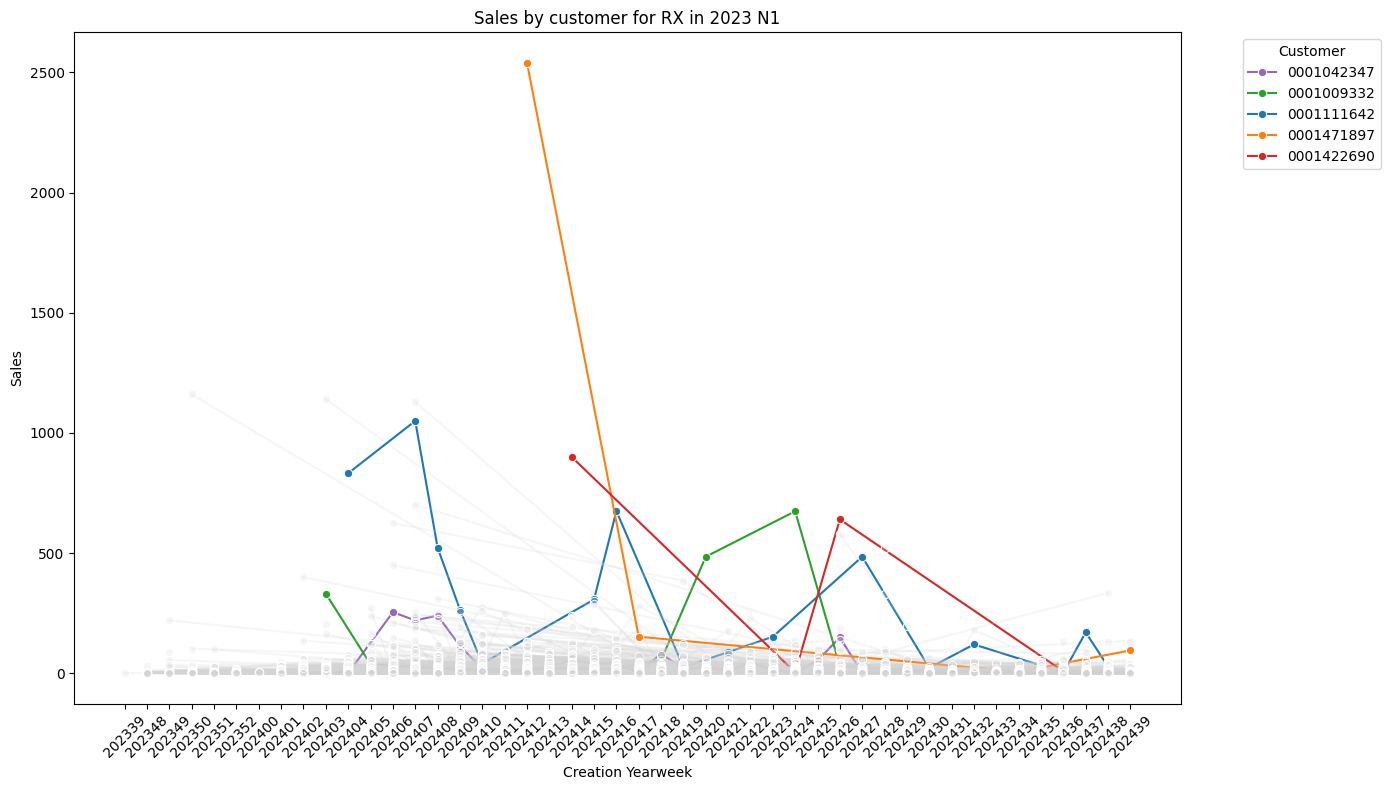

In [ ]:


data = df_final.query("brand == @brand & release == @release")

# Creating a new figure and setting its size
plt.figure(figsize=(14, 8))

# Plot for each customer, where top 5 customers are highlighted and others are in transparent gray
# Sorting customers based on total qty to ensure consistency in color assignment for top 5
# Group data by 'common_creation_yearweek' and 'customer' to sum quantities
grouped_df = data.groupby(['common_creation_yearweek', 'customer'])['qty'].sum().reset_index()
grouped_df['common_creation_yearweek'] = grouped_df['common_creation_yearweek'].astype(str)
sorted_customers = grouped_df.groupby('customer')['qty'].sum().sort_values(ascending=False).index

top_customers = grouped_df.groupby('customer')['qty'].sum().nlargest(5).index.tolist()

# Mapping each customer to a color, top 5 get distinct colors, others get transparent gray
palette = {customer: sns.color_palette()[i] if customer in top_customers else (0.83, 0.83, 0.83, 0.2) for i, customer in enumerate(sorted_customers)}

# Plotting with seaborn lineplot
sns.lineplot(data=grouped_df, x='common_creation_yearweek', y='qty', hue='customer', palette=palette, legend='full',  marker='o')

# Adjusting the legend to show top 5 customers only
handles, labels = plt.gca().get_legend_handles_labels()
new_handles = [handel  for handel, label in zip(handles, labels) if label in top_customers]
new_labels = [label  for handel, label in zip(handles, labels) if handel in new_handles]

plt.legend(new_handles, new_labels, title='Customer', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f'Sales by customer for {brand} in {release}')
plt.xlabel('Creation Yearweek')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

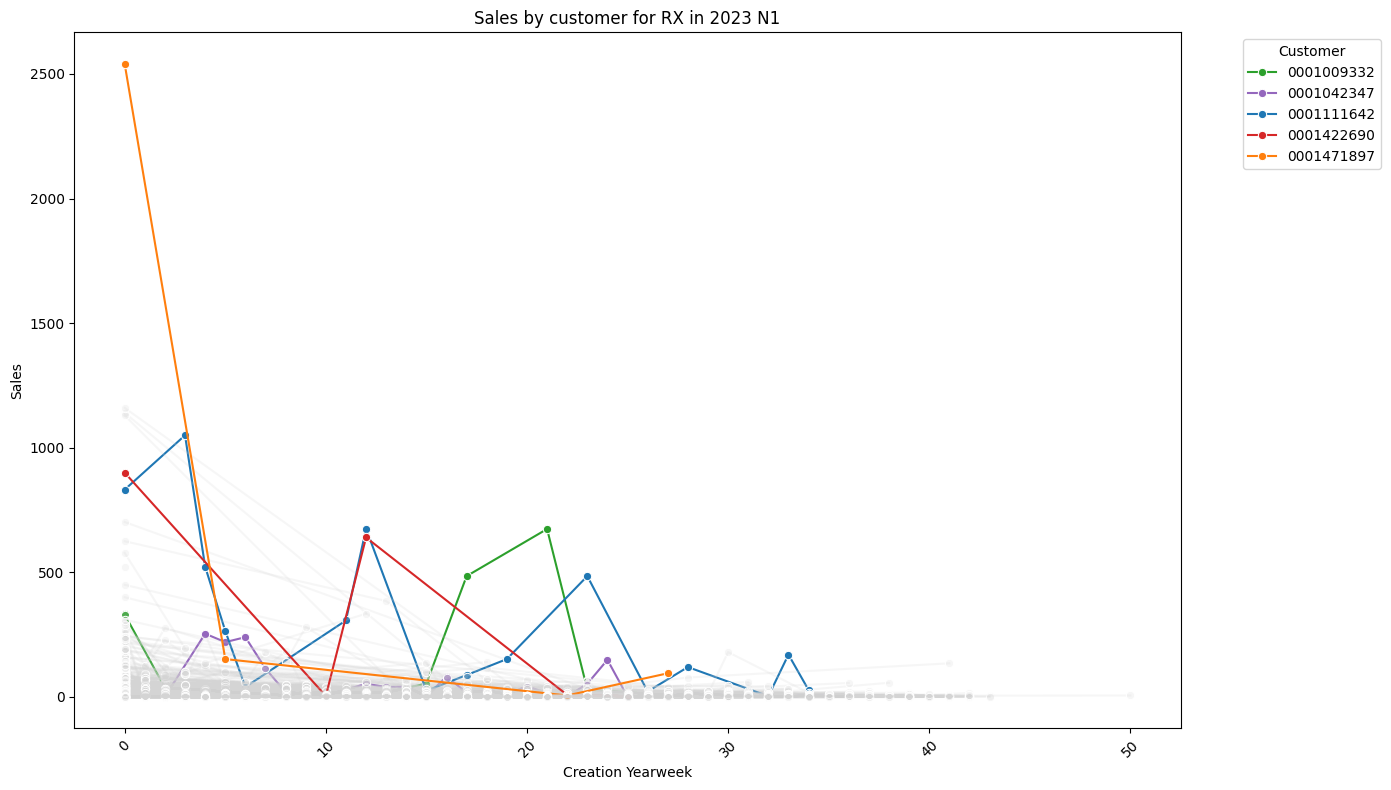

In [110]:
import datetime

data = df_final.query("brand == @brand & release == @release")

# Creating a new figure and setting its size
plt.figure(figsize=(14, 8))

# Plot for each customer, where top 5 customers are highlighted and others are in transparent gray
# Sorting customers based on total qty to ensure consistency in color assignment for top 5
# Group data by 'common_creation_yearweek' and 'customer' to sum quantities
grouped_df = data.groupby(['common_creation_yearweek', 'customer', 'first_order'])['qty'].sum().reset_index()
grouped_df = grouped_df[['customer','common_creation_yearweek', 'first_order', 'qty']].sort_values(by = ['customer','common_creation_yearweek'])



def from_yyyyww_to_date(yyyyww):
    yyyyww = str(yyyyww)
    
    year = int(yyyyww[:4])
    week = int(yyyyww[4:])
    
    first_day = datetime.datetime.strptime(f'{year}-W{week}-1', "%Y-W%W-%w")
    
    return first_day

grouped_df['common_creation_day'] = grouped_df['common_creation_yearweek'].apply(lambda x: from_yyyyww_to_date(x))


dict_customer_first_date = grouped_df.query("first_order == True")[['customer', 'common_creation_day']].drop_duplicates().reset_index(drop=True)



group_df_first = grouped_df.merge(dict_customer_first_date, on = 'customer', suffixes=["",'_first'])

group_df_first['step'] = (group_df_first['common_creation_day'] - group_df_first['common_creation_day_first']).dt.days // 7


sorted_customers = group_df_first.groupby('customer')['qty'].sum().sort_values(ascending=False).index

top_customers = group_df_first.groupby('customer')['qty'].sum().nlargest(5).index.tolist()

# Mapping each customer to a color, top 5 get distinct colors, others get transparent gray
palette = {customer: sns.color_palette()[i] if customer in top_customers else (0.83, 0.83, 0.83, 0.2) for i, customer in enumerate(sorted_customers)}

# Plotting with seaborn lineplot
sns.lineplot(data=group_df_first, x='step', y='qty', hue='customer', palette=palette, legend='full',  marker='o')

# Adjusting the legend to show top 5 customers only
handles, labels = plt.gca().get_legend_handles_labels()
new_handles = [handel  for handel, label in zip(handles, labels) if label in top_customers]
new_labels = [label  for handel, label in zip(handles, labels) if handel in new_handles]

plt.legend(new_handles, new_labels, title='Customer', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title(f'Sales by customer for {brand} in {release}')
plt.xlabel('Creation Yearweek')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [104]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49009 entries, 1935 to 20979
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer                  49009 non-null  object        
 1   common_creation_yearweek  49009 non-null  int64         
 2   first_order               49009 non-null  bool          
 3   qty                       49009 non-null  int32         
 4   common_creation_day       49009 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 1.7+ MB


In [108]:
group_df_first

,customer,common_creation_yearweek,first_order,qty,common_creation_day,common_creation_day_first,step
0,0000100000,202404,True,32,2024-01-22,2024-01-22,0
1,0000100000,202408,False,3,2024-02-19,2024-01-22,4
2,0000100000,202418,False,1,2024-04-29,2024-01-22,14
3,0000100000,202435,False,16,2024-08-26,2024-01-22,31
4,0000100000,202436,False,5,2024-09-02,2024-01-22,32
...,...,...,...,...,...,...,...
49004,0006000535,202436,True,17,2024-09-02,2024-09-02,0
49005,0006000665,202436,True,21,2024-09-02,2024-09-02,0
49006,0006001951,202436,True,3,2024-09-02,2024-09-02,0
49007,0006002235,202436,True,1,2024-09-02,2024-09-02,0


In [52]:
for data in range(202400, 202453):
    print(from_yyyyww_to_date(data))

2024-01-01
2024-01-01
2024-01-08
2024-01-15
2024-01-22
2024-01-29
2024-02-05
2024-02-12
2024-02-19
2024-02-26
2024-03-04
2024-03-11
2024-03-18
2024-03-25
2024-04-01
2024-04-08
2024-04-15
2024-04-22
2024-04-29
2024-05-06
2024-05-13
2024-05-20
2024-05-27
2024-06-03
2024-06-10
2024-06-17
2024-06-24
2024-07-01
2024-07-08
2024-07-15
2024-07-22
2024-07-29
2024-08-05
2024-08-12
2024-08-19
2024-08-26
2024-09-02
2024-09-09
2024-09-16
2024-09-23
2024-09-30
2024-10-07
2024-10-14
2024-10-21
2024-10-28
2024-11-04
2024-11-11
2024-11-18
2024-11-25
2024-12-02
2024-12-09
2024-12-16
2024-12-23


In [39]:
group_df_first

,customer,common_creation_yearweek,first_order,qty,common_creation_yearweek_first,step
0,0000100000,202404,True,32,202404,0
1,0000100000,202408,False,3,202404,4
2,0000100000,202418,False,1,202404,14
3,0000100000,202435,False,16,202404,31
4,0000100000,202436,False,5,202404,32
...,...,...,...,...,...,...
49004,0006000535,202436,True,17,202436,0
49005,0006000665,202436,True,21,202436,0
49006,0006001951,202436,True,3,202436,0
49007,0006002235,202436,True,1,202436,0


In [8]:
(202302-202252) % 48

2

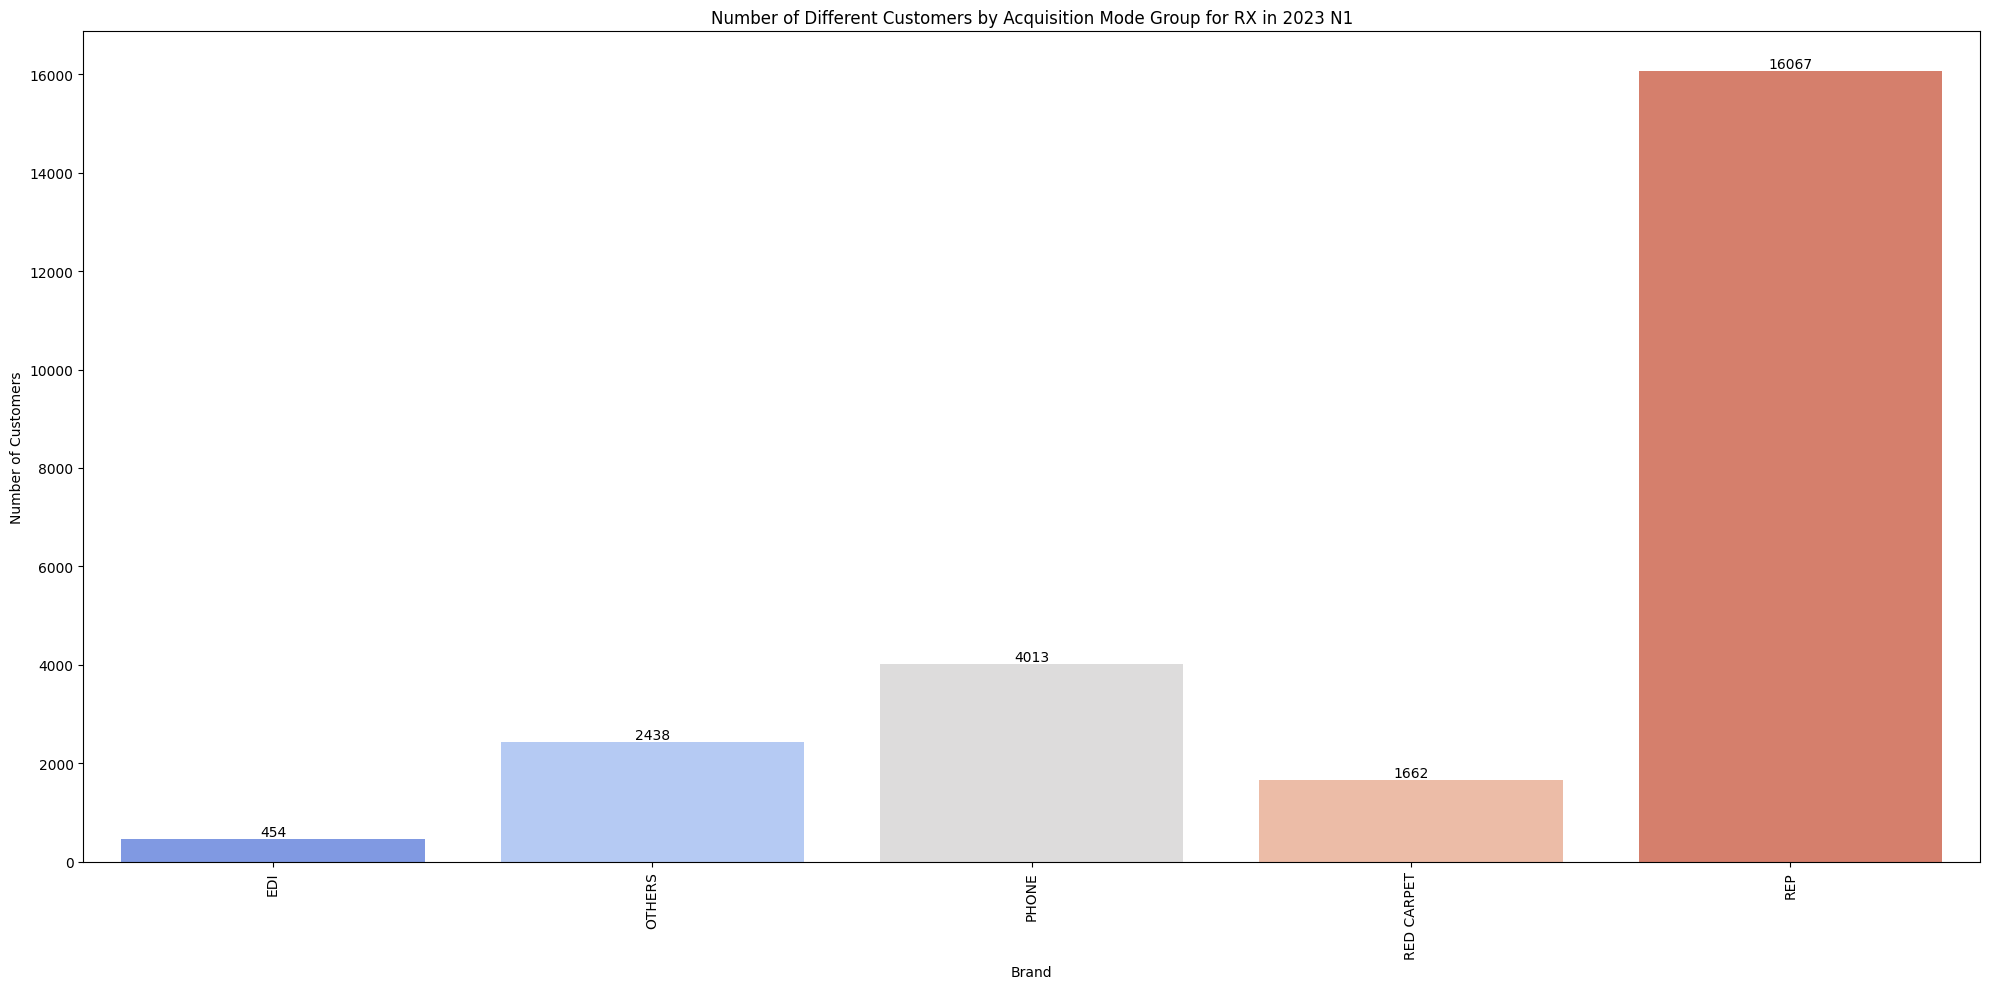

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
df_first_order = data[data['first_order'] == True]
# Count the number of different customers using a certain acquisition_mode_group for each brand
customer_counts = df_first_order.groupby(['brand', 'acquisition_mode_group'])['customer'].nunique().reset_index(name='customer_count')

# Pivot for better plotting with seaborn
pivot_data = customer_counts.pivot(index='brand', columns='acquisition_mode_group', values='customer_count').fillna(0)

# Plot
plt.figure(figsize=(20, 10))
ax= sns.barplot(data=pivot_data, palette="coolwarm")
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=90)
plt.ylabel('Number of Customers')
plt.xlabel('Brand')
plt.title(f'Number of Different Customers by Acquisition Mode Group for {brand} in {release}')
plt.tight_layout()

plt.show()


/var/folders/4n/7zm_f9b959gbsyh_5ld2nw_80000gn/T/ipykernel_56485/229681115.py:11: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(data=pivot_qty_data, palette="coolwarm", errwidth=0 )


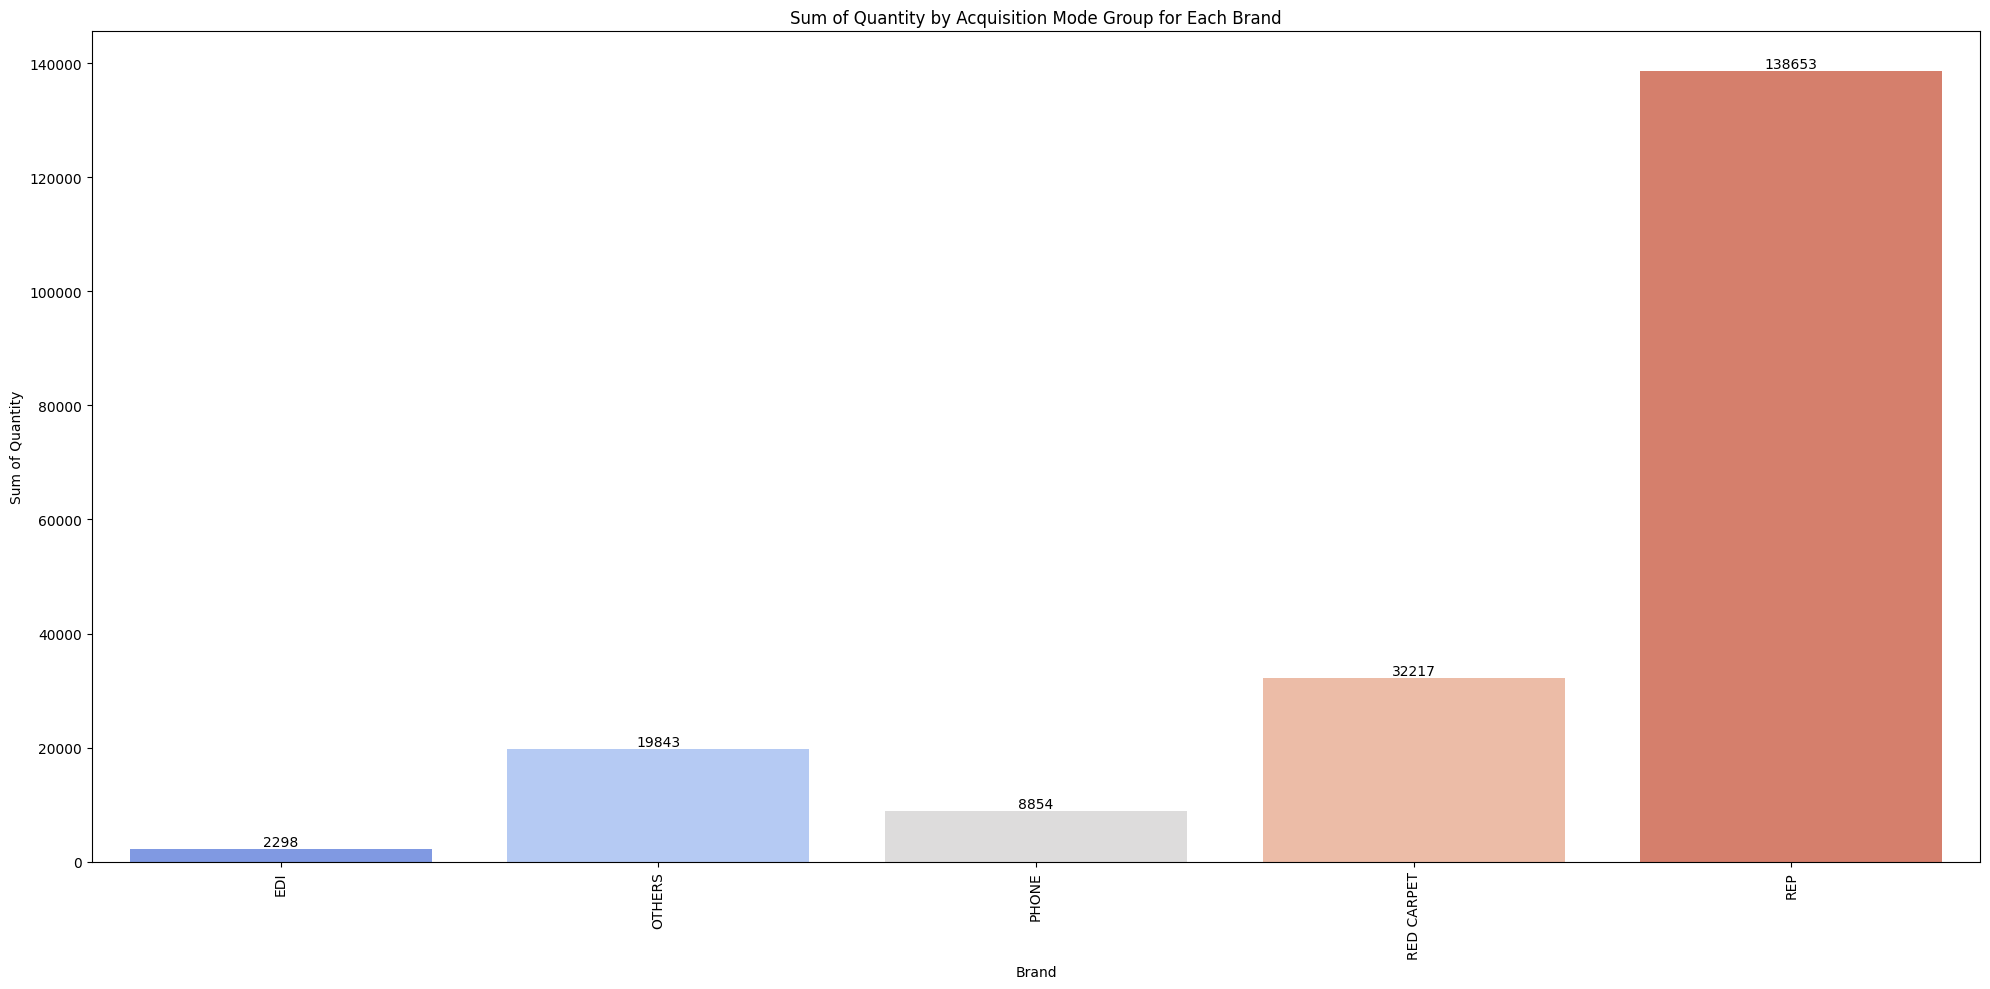

In [26]:
# Sum up the 'qty' column for each acquisition_mode_group for each brand


qty_sums = df_first_order.groupby(['brand', 'acquisition_mode_group'])['qty'].sum().reset_index(name='qty_sum')

# Pivot for better plotting with seaborn
pivot_qty_data = qty_sums.pivot(index='brand', columns='acquisition_mode_group', values='qty_sum').fillna(0)

# Plot
plt.figure(figsize=(20, 10))
ax = sns.barplot(data=pivot_qty_data, palette="coolwarm", errwidth=0 )
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=90)
plt.ylabel('Sum of Quantity')
plt.xlabel('Brand')
plt.title('Sum of Quantity by Acquisition Mode Group for Each Brand')
plt.tight_layout()

plt.show()


<Figure size 2000x1000 with 0 Axes>

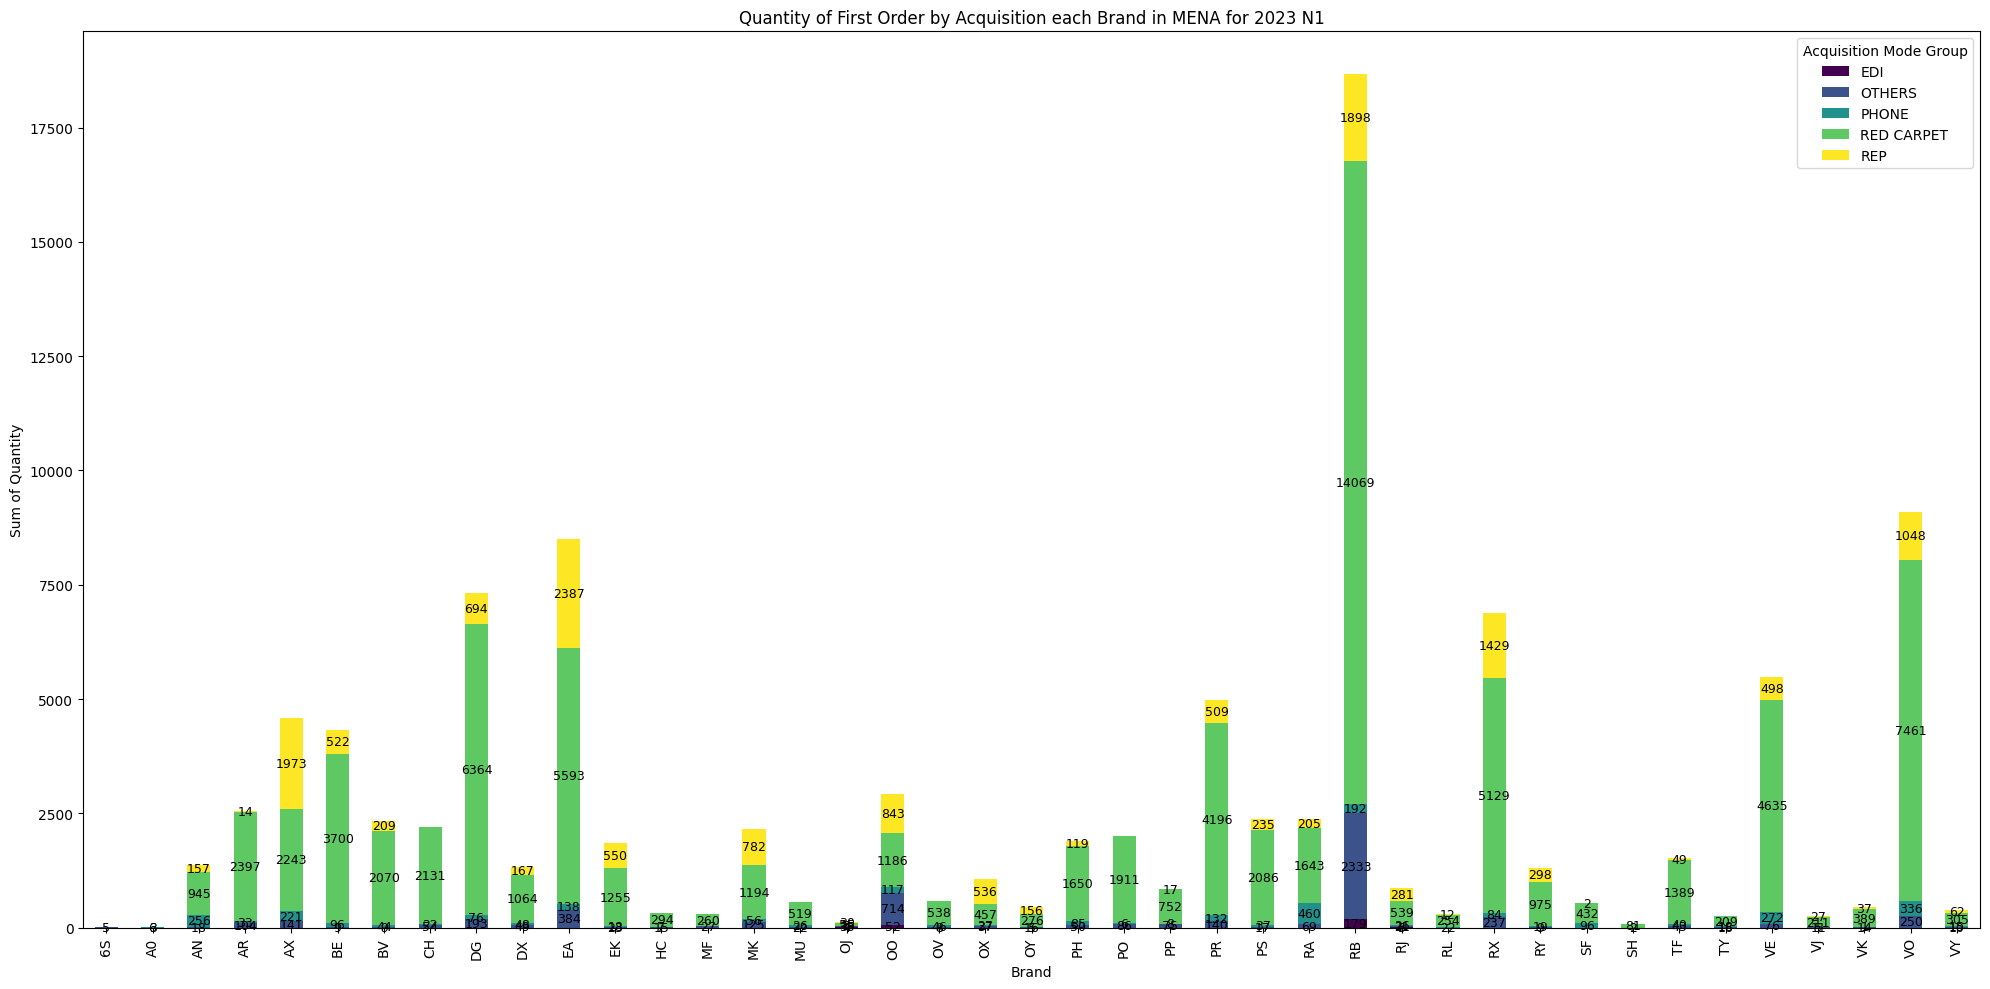

<Figure size 2000x1000 with 0 Axes>

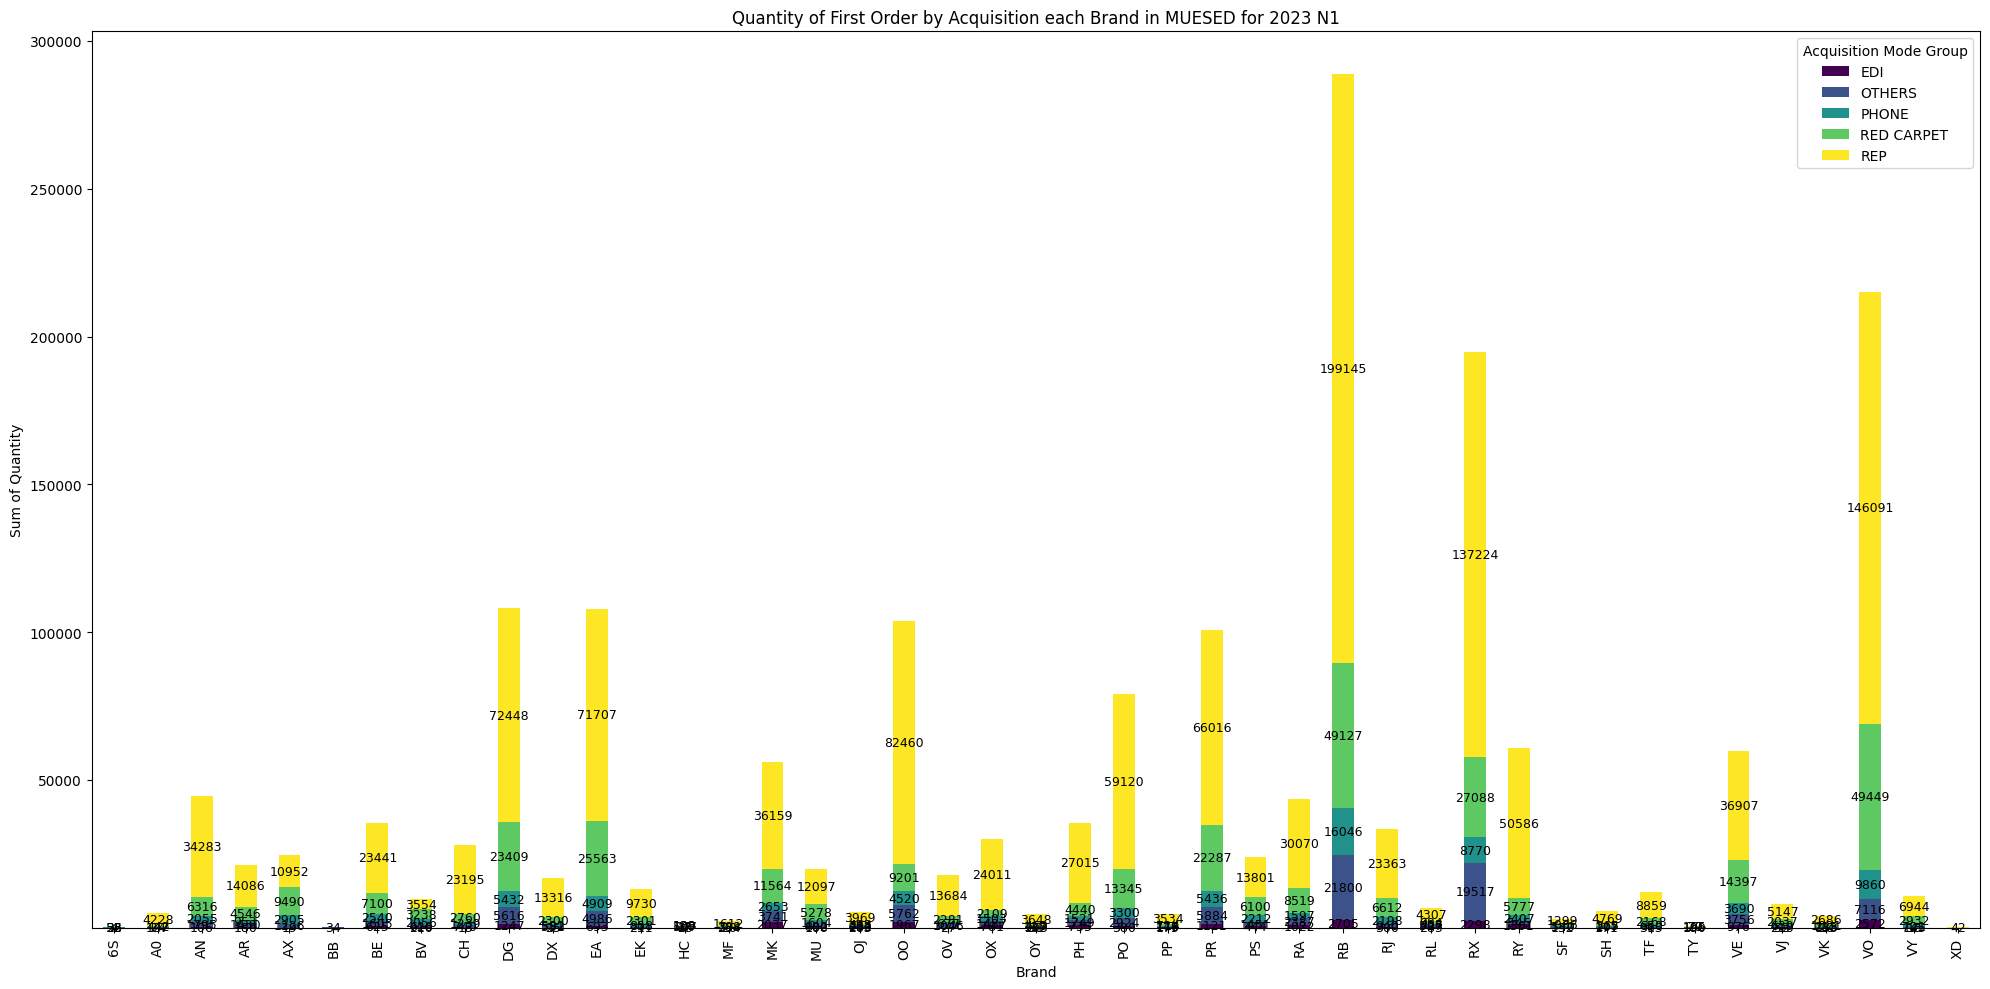

<Figure size 2000x1000 with 0 Axes>

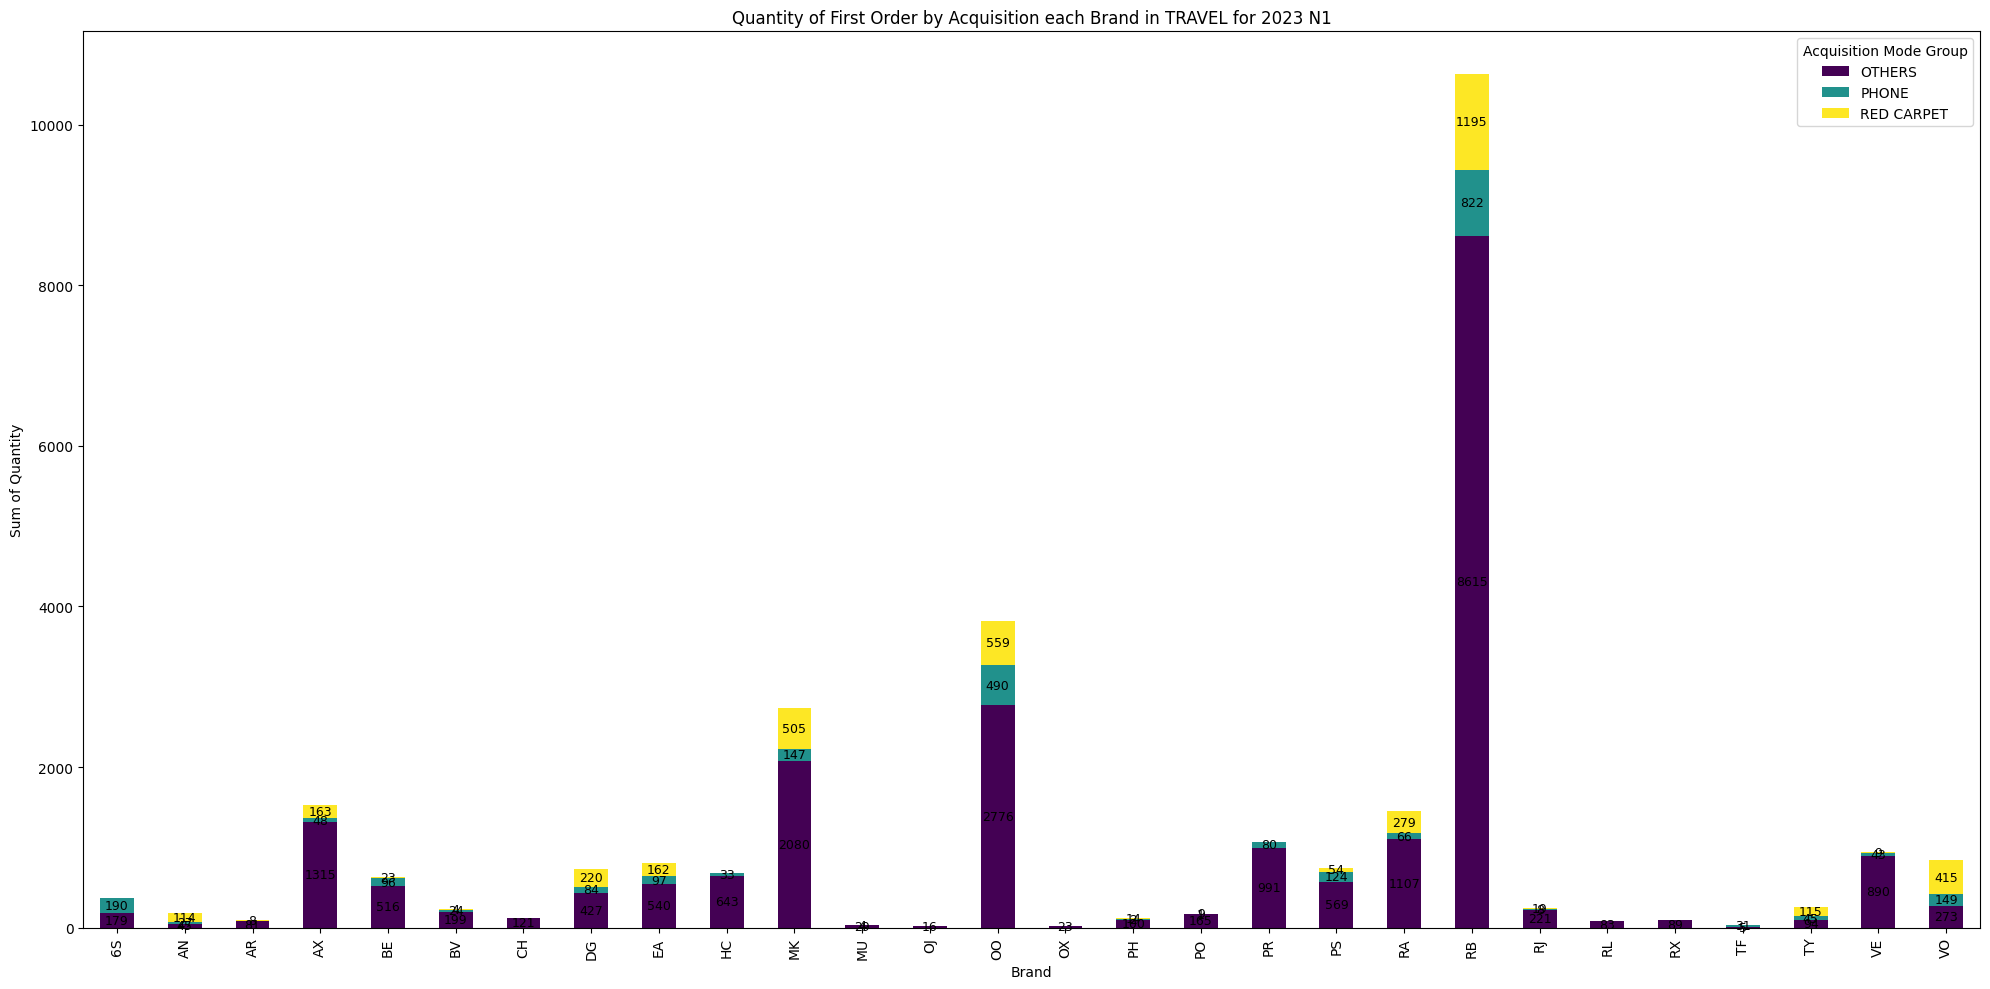

<Figure size 2000x1000 with 0 Axes>

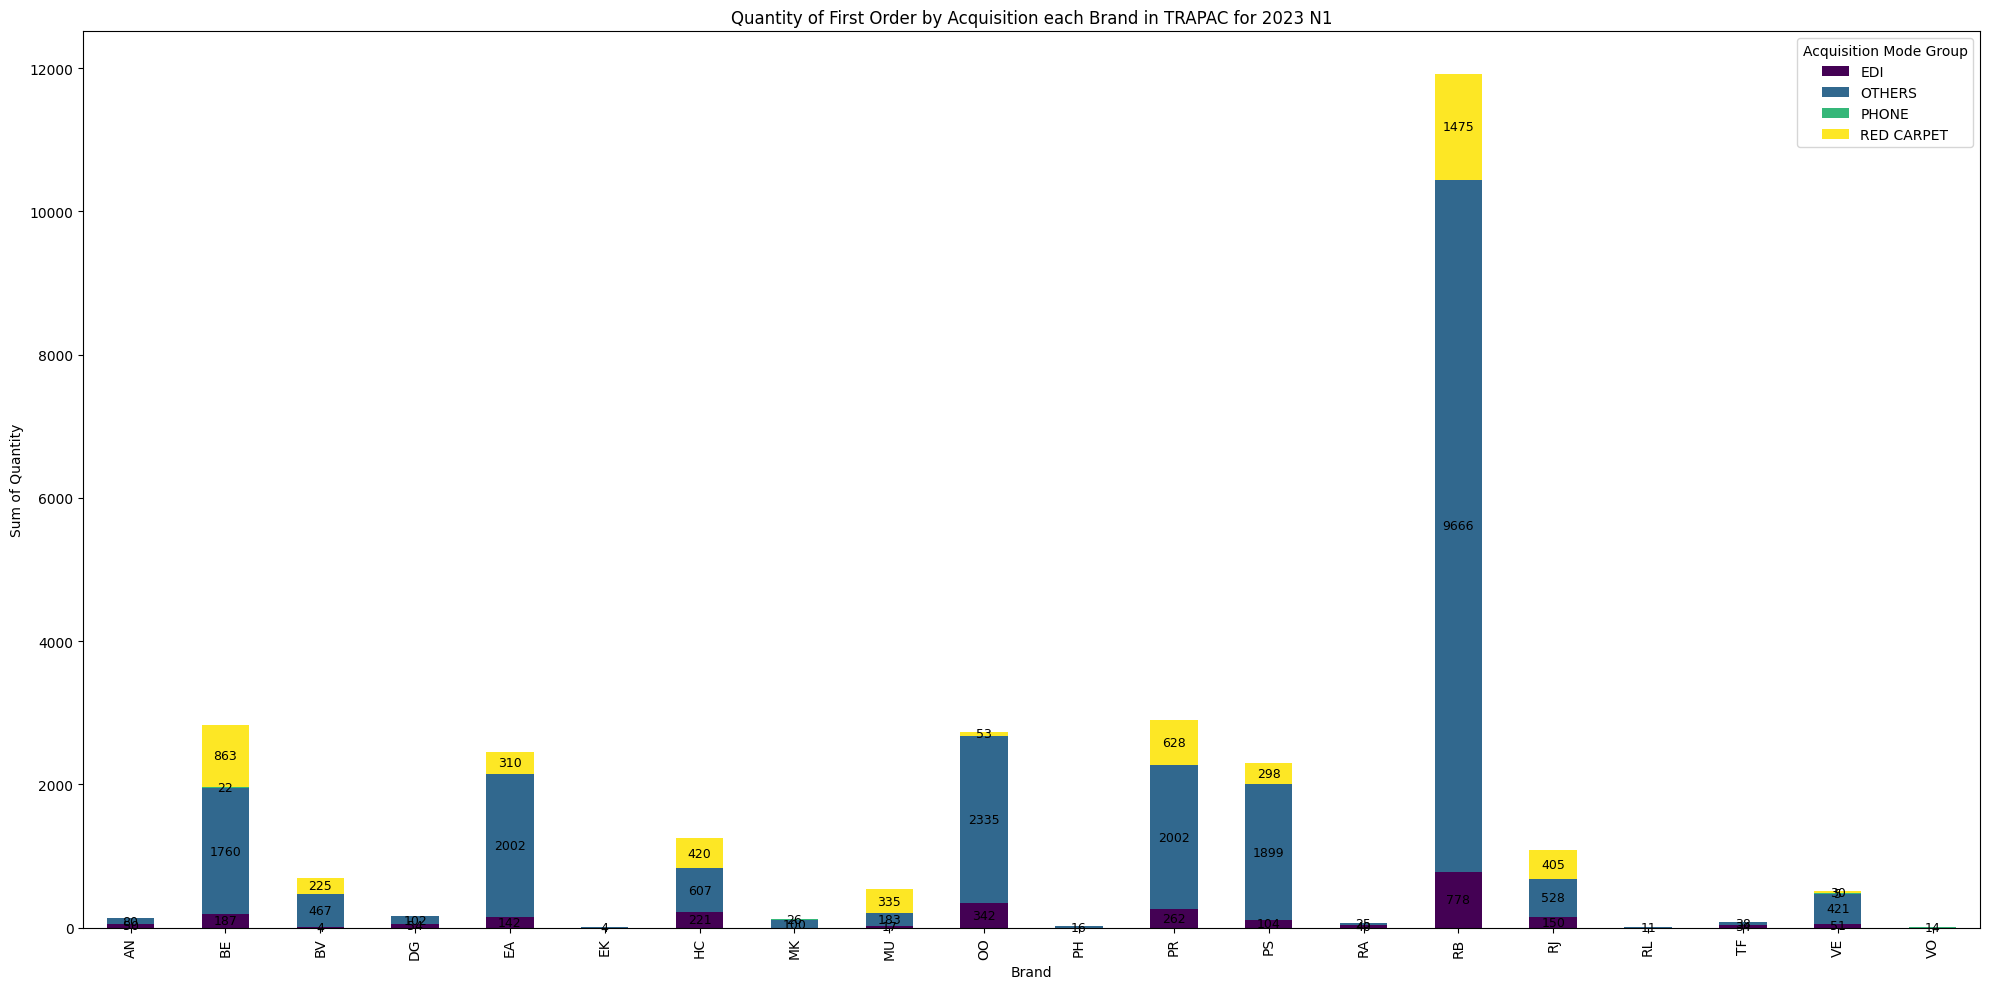

In [41]:
# Plot with sum of quantities and values on top of each bar
for area in df_final.dedalo_area.unique():
    
    plt.figure(figsize=(20, 10))
    df_first_order = df_final[(df_final['first_order'] == True) & (df_final['dedalo_area'] == area) & (df_final['release'] == release)]
    qty_sums = df_first_order.groupby(['brand', 'acquisition_mode_group'])['qty'].sum().reset_index(name='qty_sum')

    # Pivot for better plotting with seaborn
    pivot_qty_data = qty_sums.pivot(index='brand', columns='acquisition_mode_group', values='qty_sum').fillna(0)

    # Use seaborn to create a stacked bar plot
    pivot_qty_data.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='viridis')

    plt.ylabel('Sum of Quantity')
    plt.xlabel('Brand')
    plt.title(fr'Quantity of First Order by Acquisition each Brand in {area} for {release}')
    plt.xticks(rotation=90)
    plt.legend(title='Acquisition Mode Group')

    # Annotate values on top of each bar
    for i, brand in enumerate(pivot_qty_data.index):
        for acquisition_mode_group, qty_sum in pivot_qty_data.loc[brand].items():
            if qty_sum > 0:  # Only annotate non-zero values
                plt.text(i, pivot_qty_data.loc[brand, :].cumsum()[acquisition_mode_group] - (qty_sum/2), int(qty_sum), ha='center', va='center', color='black', fontsize=9)

    plt.tight_layout()

    plt.show()


<Figure size 2000x1000 with 0 Axes>

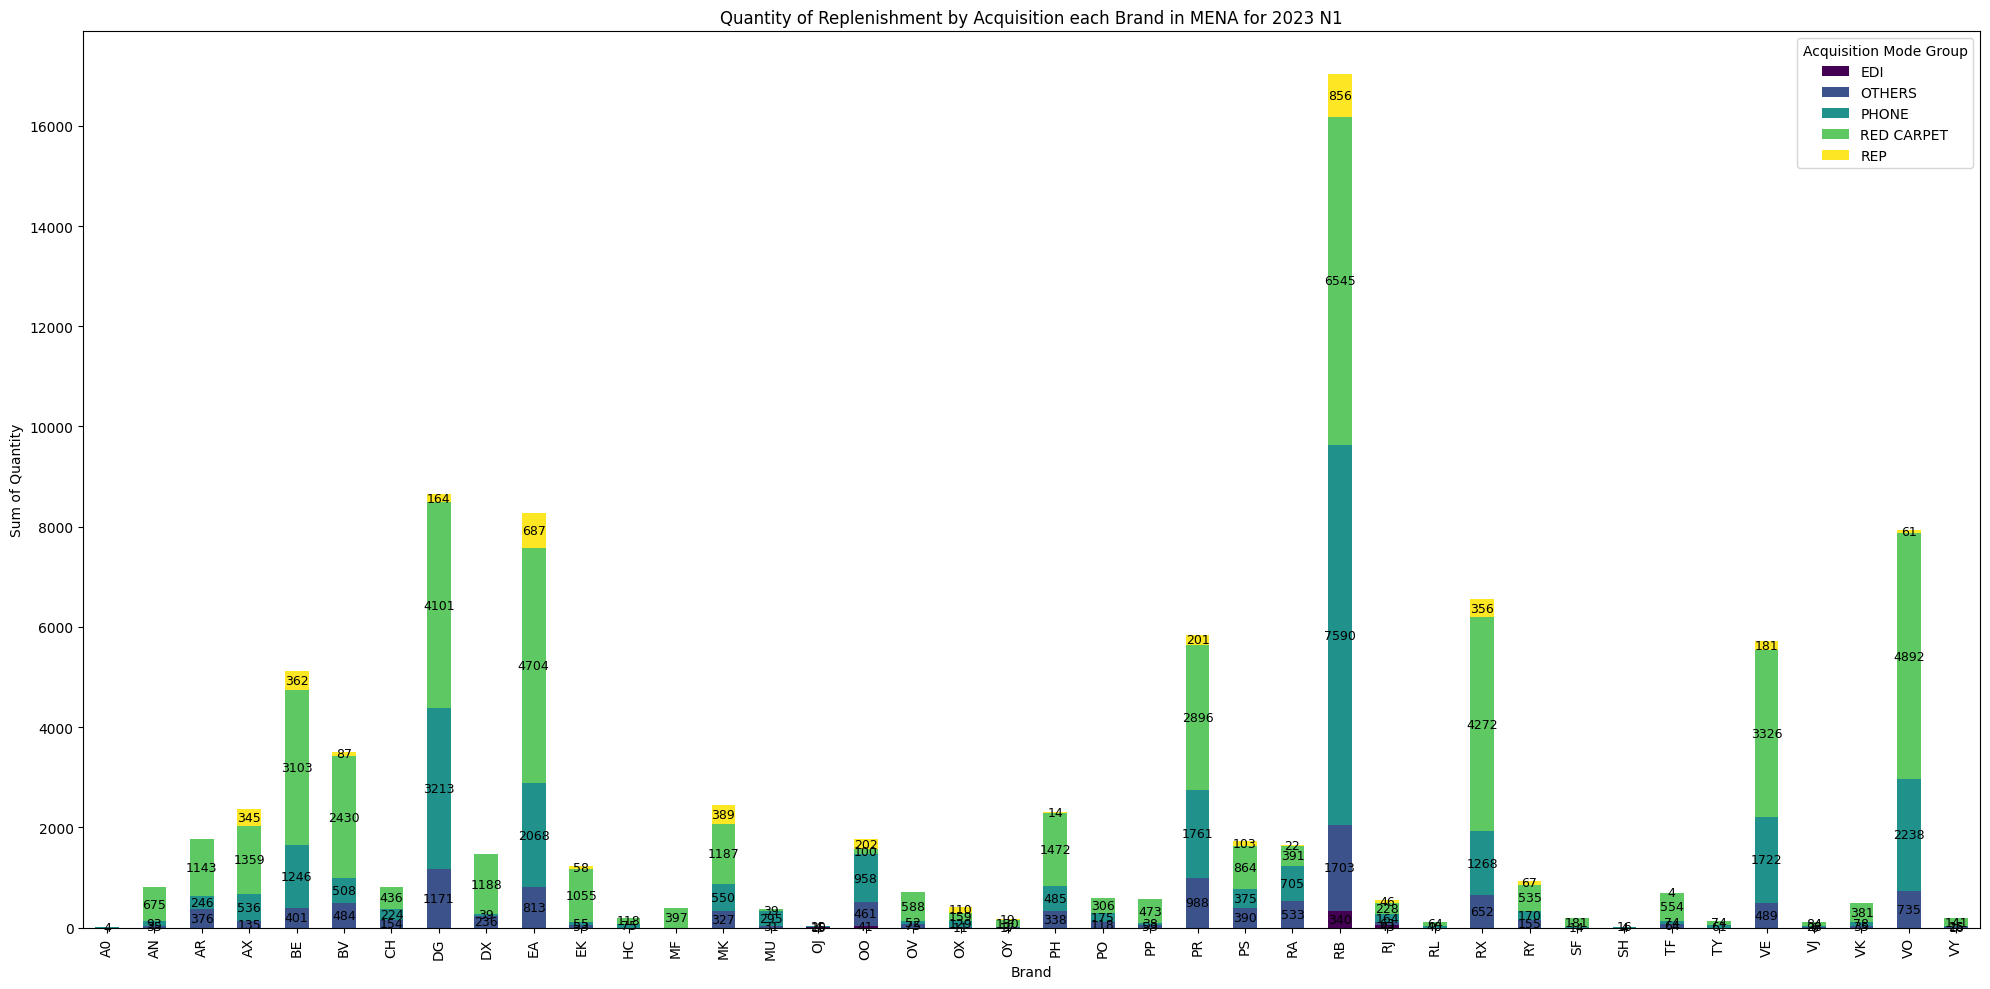

<Figure size 2000x1000 with 0 Axes>

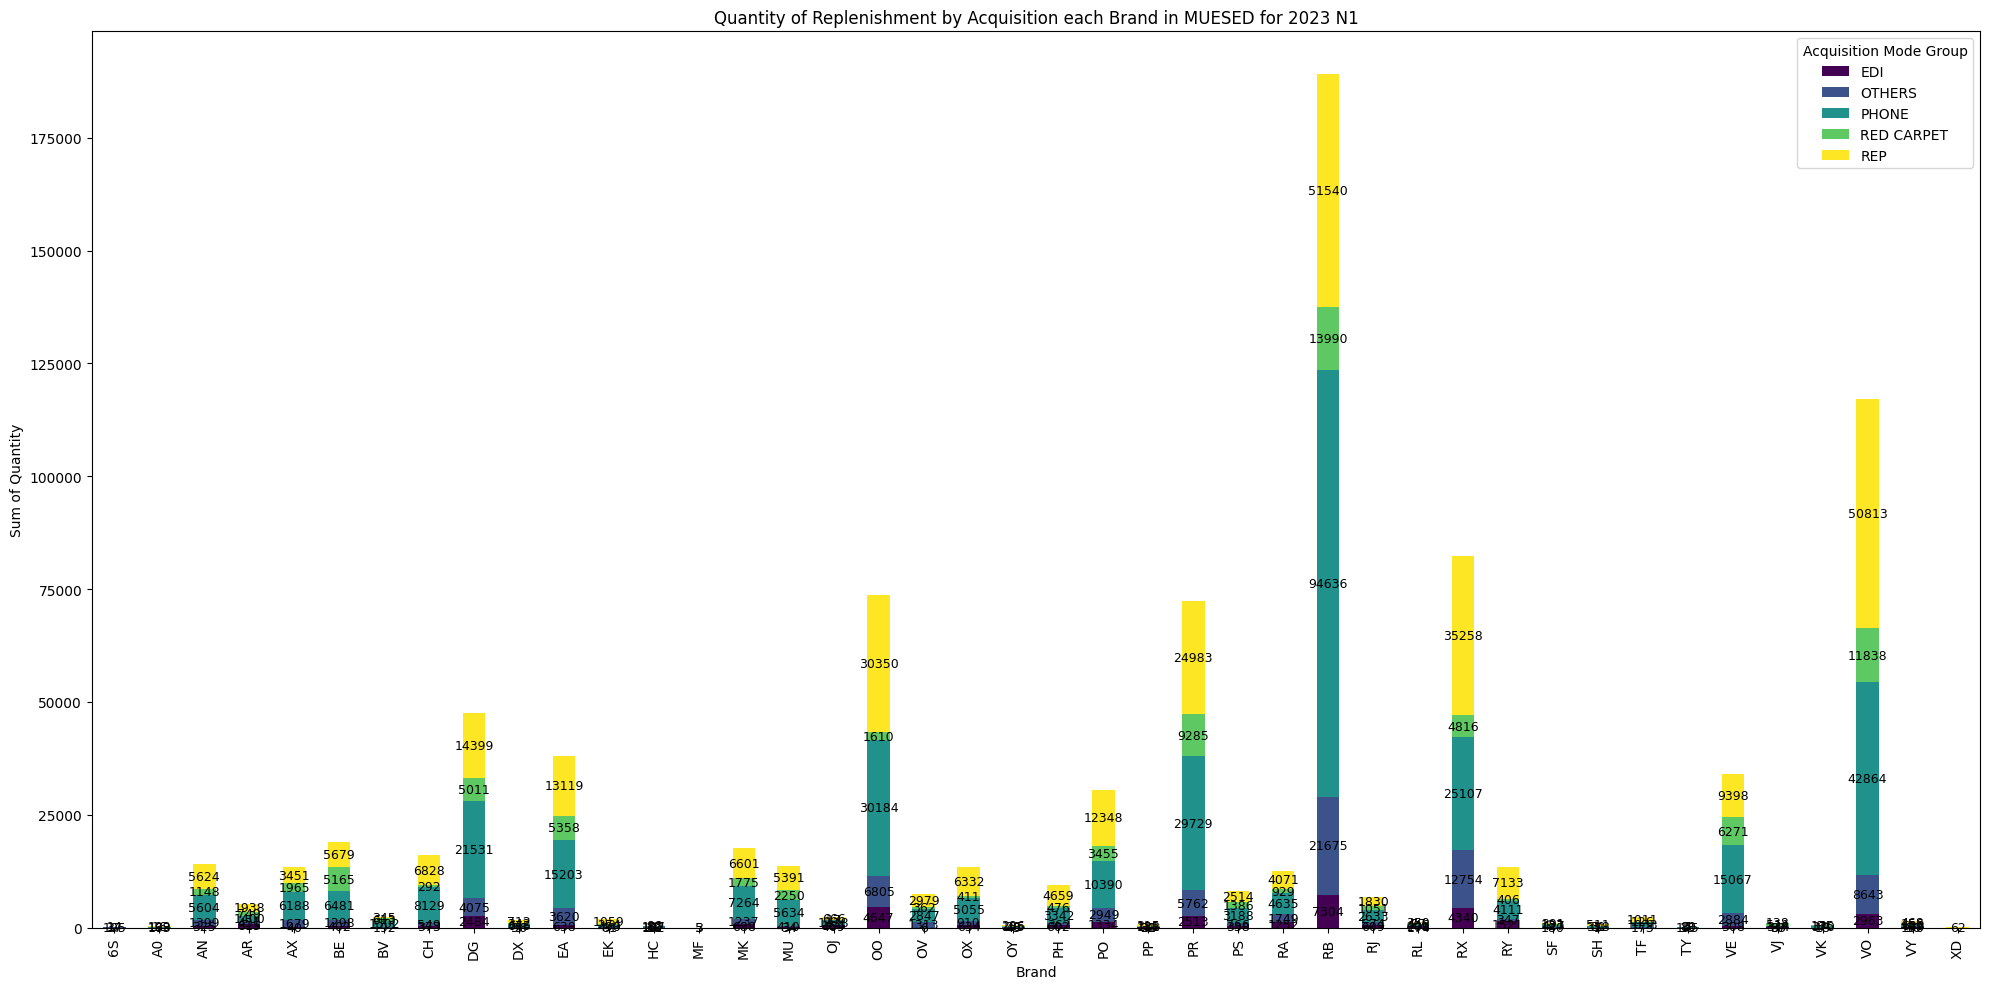

<Figure size 2000x1000 with 0 Axes>

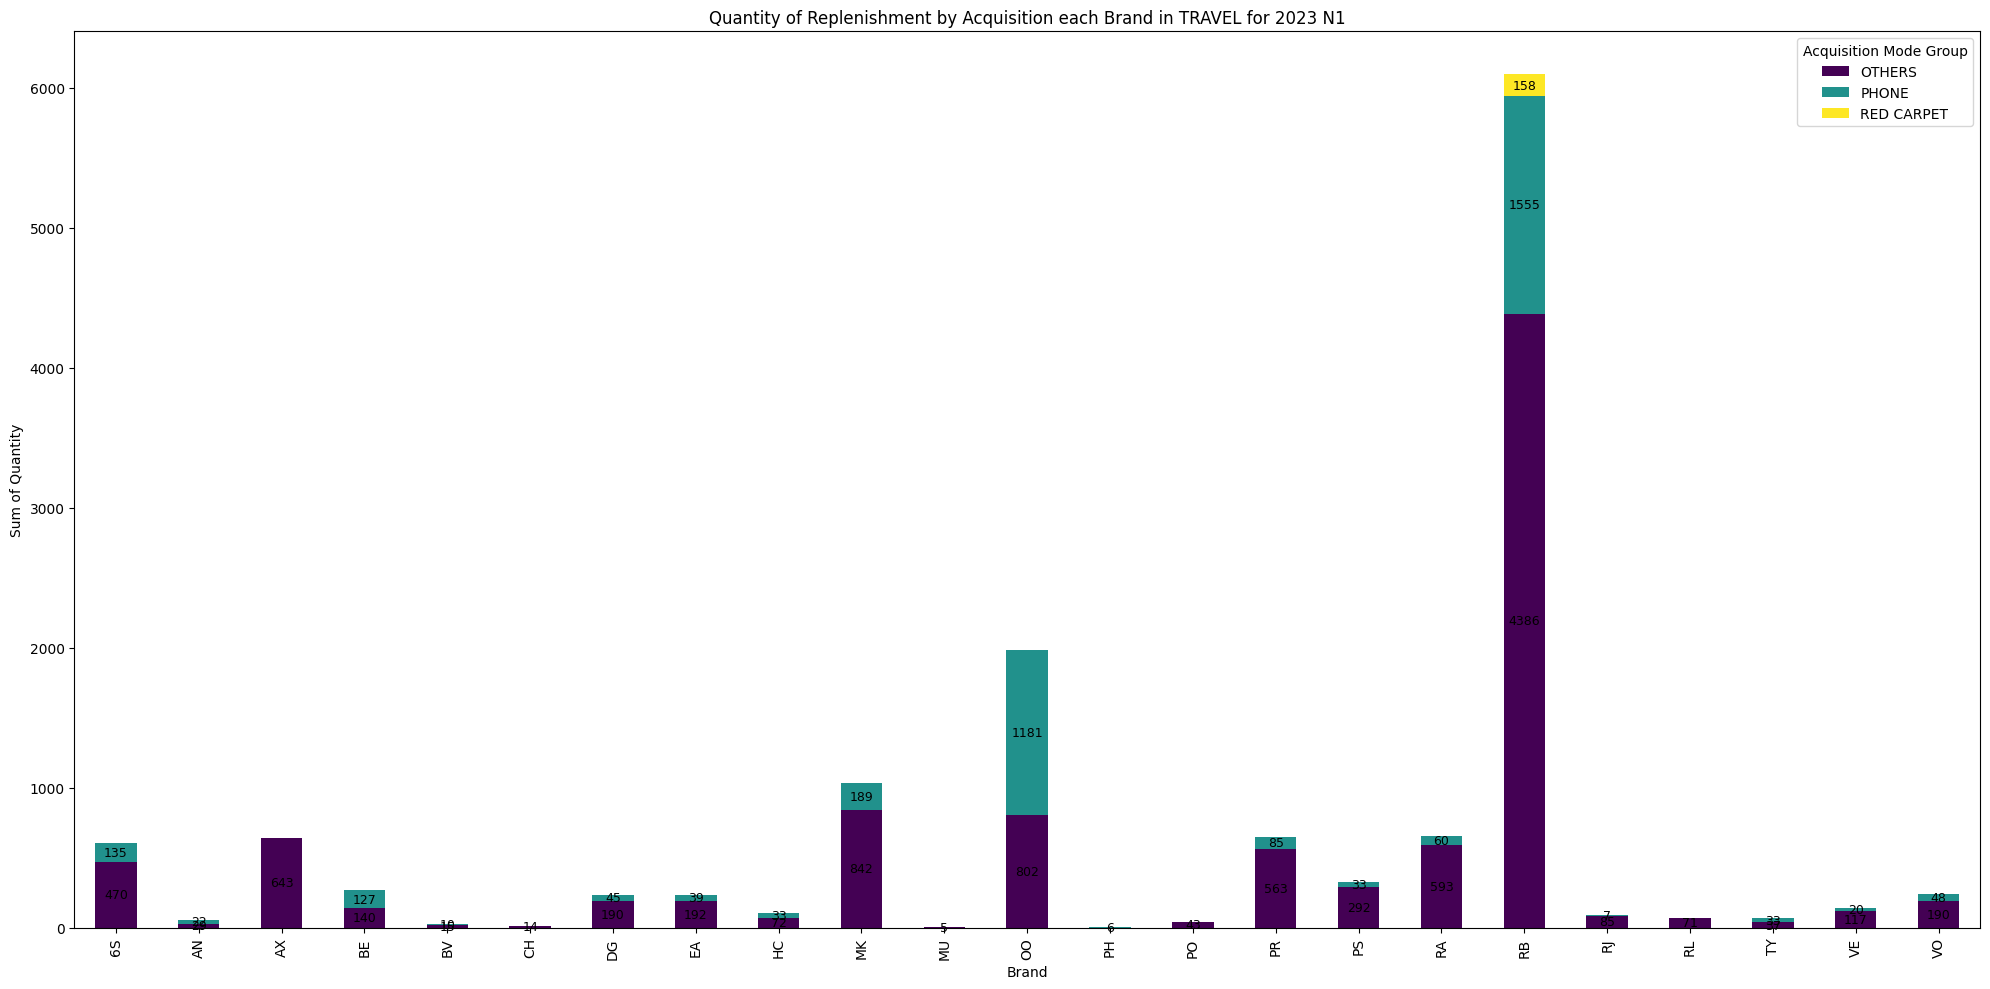

<Figure size 2000x1000 with 0 Axes>

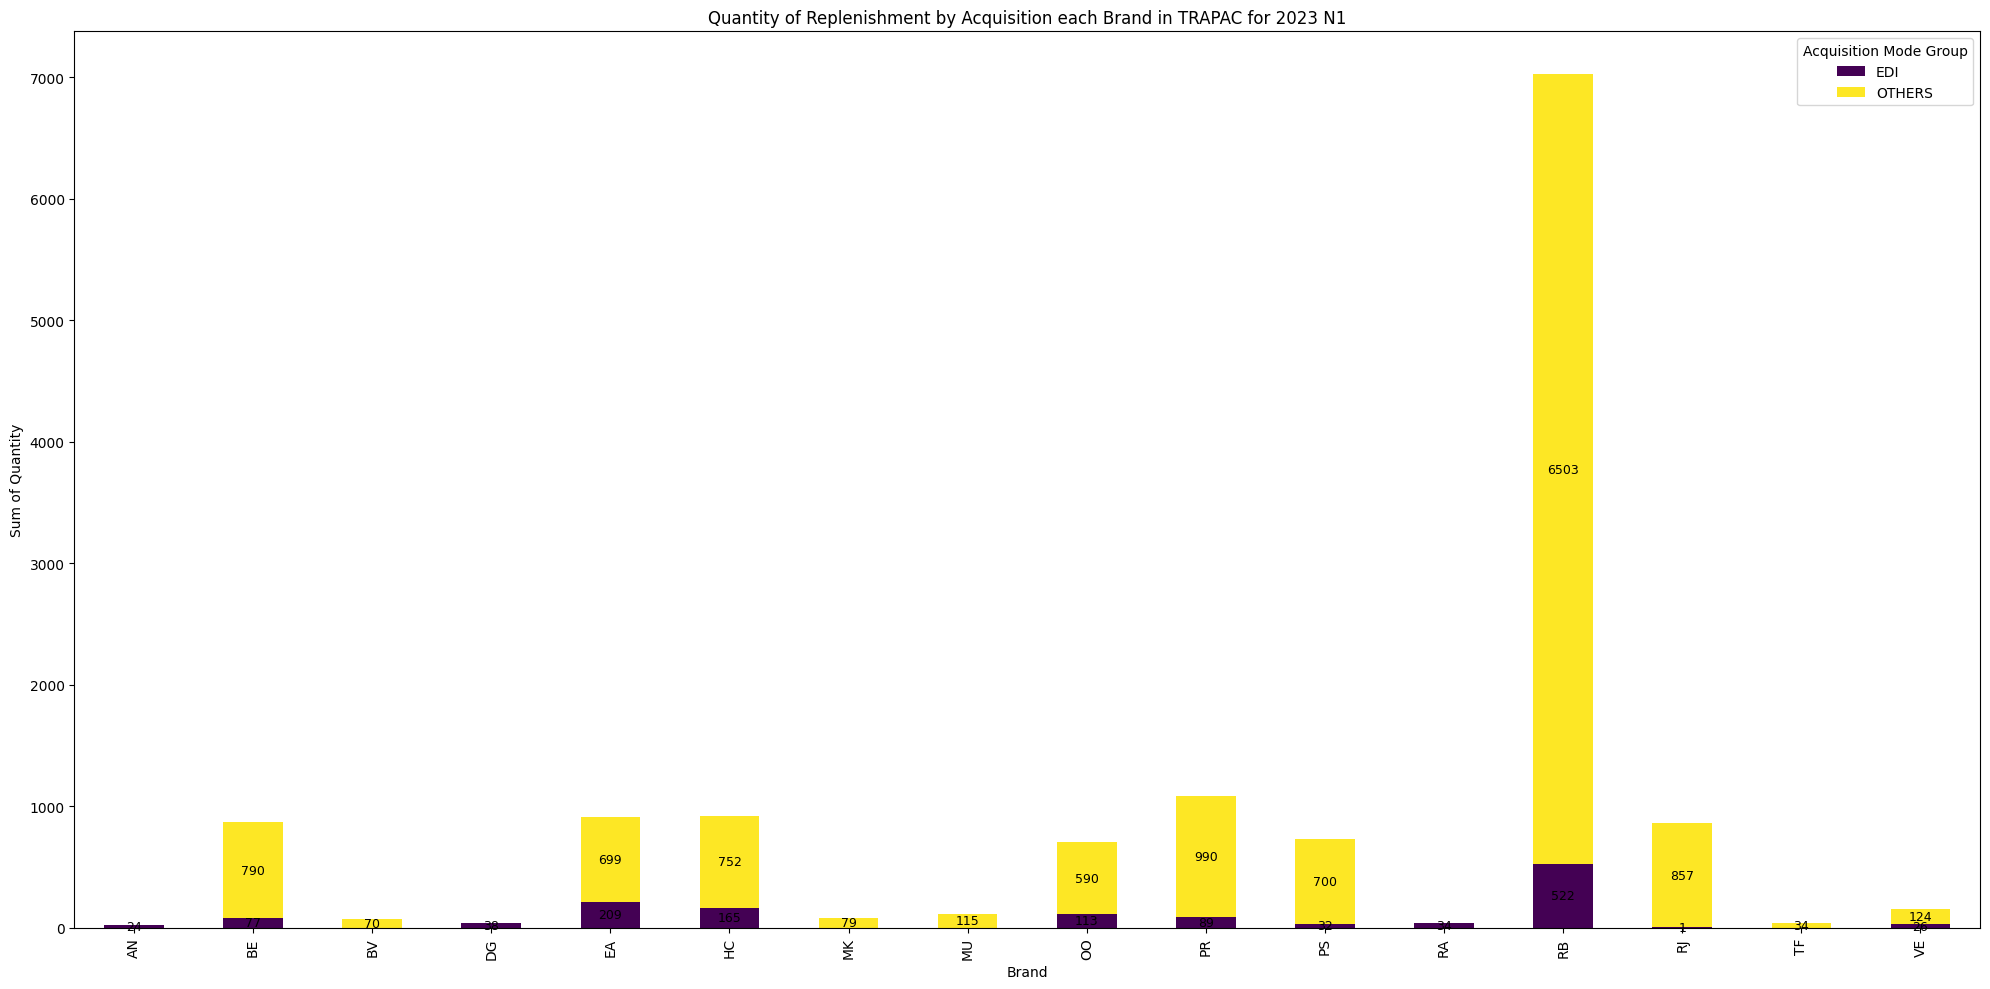

In [42]:
# Plot with sum of quantities and values on top of each bar
for area in df_final.dedalo_area.unique():
    
    plt.figure(figsize=(20, 10))
    df_first_order = df_final[(df_final['first_order'] == False) & (df_final['dedalo_area'] == area) & (df_final['release'] == release)]
    qty_sums = df_first_order.groupby(['brand', 'acquisition_mode_group'])['qty'].sum().reset_index(name='qty_sum')

    # Pivot for better plotting with seaborn
    pivot_qty_data = qty_sums.pivot(index='brand', columns='acquisition_mode_group', values='qty_sum').fillna(0)

    # Use seaborn to create a stacked bar plot
    pivot_qty_data.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='viridis')

    plt.ylabel('Sum of Quantity')
    plt.xlabel('Brand')
    plt.title(fr'Quantity of Replenishment by Acquisition each Brand in {area} for {release}')
    plt.xticks(rotation=90)
    plt.legend(title='Acquisition Mode Group')

    # Annotate values on top of each bar
    for i, brand in enumerate(pivot_qty_data.index):
        for acquisition_mode_group, qty_sum in pivot_qty_data.loc[brand].items():
            if qty_sum > 0:  # Only annotate non-zero values
                plt.text(i, pivot_qty_data.loc[brand, :].cumsum()[acquisition_mode_group] - (qty_sum/2), int(qty_sum), ha='center', va='center', color='black', fontsize=9)

    plt.tight_layout()

    plt.show()
